In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
import gensim
# from keras import layers
# from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
# from sklearn.cluster import MiniBatchKMean

In [4]:

data = pd.read_csv('train.csv/train.csv')



data['is_toxic'] = np.where((data['toxic'] + data['severe_toxic'] + data['obscene']+ data['threat'] + data['insult'] + data['identity_hate'])!= 0, 1, 0)
# data.head()
# data[data['is_toxic'] == 1].head()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"can't","cannot",text)
    text = re.sub(r"n't"," not",text) # see the space before not. 
    text = re.sub(r"i'm","i am",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"let's","let us",text)
    text = re.sub(r"shan't","shall not",text)
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"'re"," are",text)
    text = re.sub(r"'s"," ",text) 
    text = re.sub(r"'ve"," have",text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)  
    text = re.sub('\s+', ' ', text) 
    text = text.strip(' ') 
    return text
data['comment_text'] = data['comment_text'].apply(lambda x: clean_text(x))
data = data.loc[((data['comment_text'].str.contains('{', regex = False) - 1)* -1).astype(bool)]


In [6]:
# IMBALANCED LEARN STUFF
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss

In [7]:
from sklearn.model_selection import KFold
from collections import defaultdict
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
def undersample(x, y, method = RandomUnderSampler(random_state = 1), return_all = True):
    '''
    x: x data
    y: y data
    method: undersampling method to be used
    return_all: if we want to return the y of the undersampled as well
    
    returns: Undersampled x, <<undersampled y if return_all>>
    '''
    if return_all:
        return method.fit_resample(x,y)
    return method.fit_resample(x,y)[0]

def transform_to_useable(x):
    '''
    x: x that still the comment text as well as possibly other catiggories
    
    returns: vecotrized comment text, df of columns in x other then comment text
    '''
    tfd = TfidfVectorizer(stop_words='english',max_features=5000)
    X = tfd.fit_transform(x['comment_text'])
    y = x.loc[:, x.columns != 'comment_text']
    return X, y


def k_fold_val(X, y, models = [LogisticRegression(C = 12, max_iter = 500)], folds = 5):
    '''
    X: the x of the data
    y: the result of the data
    models: the models that we want tested
    folds: number of kfolds to do
    
    return: {(model, catigory_modeled): {
        'report': [classification report from kfolds]
        'acc': [acc scores from kfolds]
        'f1': [f1 score from kfolds]
        'recall': [recall from kfolds]
    }}
    '''
    kf = KFold(n_splits = folds)
#     print(X.shape[0], len(y))
    kf.get_n_splits(X)
    results = defaultdict(list)
    for model in models:
        for cat in y:
            print(f'doing kfold for {model} on {cat}')
            for i, (train, test) in enumerate(kf.split(X)):
#                 print(y[cat].head)
                y_sub = np.asarray(y[cat])
#                 print(y_sub.head())
#                 print(y_sub.iloc(train))
#                 y_sub = y[cat]
#                 print(y_sub.shape())
#                 print(X)
#                 print(y_sub[train])
                model.fit(X[train], y_sub[train])
                # might want to add in train results
                y_pred = model.predict(X[test])

                results[(model, cat)].append({'report': classification_report(y_sub[test], y_pred),
                                             'acc':accuracy_score(y_sub[test], y_pred),
                                             'f1': f1_score(y_sub[test], y_pred),
                                             'recall': recall_score(y_sub[test], y_pred),
                                             })
    return results

def full_run(x, y, undersample_method = RandomUnderSampler(random_state = 1), combined_x_y = True, models = [LogisticRegression(C = 12, max_iter = 500)], folds = 5):
    '''
    ALL BEFORE UNDERSAMPLING
    X: the x data before vectorization
    y: the labels of data
    
    undersample_method: the way to undersample, might be able to use oversample as well? need to check
    combined_x_y: Is the data for Y inside of X, did you create a seperate classification to do undersampling
    models: the models to be tested
    folds: number of of kfolds to test
    
    return: {(model, catigory_modeled): {
        'report': [classification report from kfolds]
        'acc': [acc scores from kfolds]
        'f1': [f1 score from kfolds]
        'recall': [recall from kfolds]
    }}
    '''
    
    if combined_x_y:
        X = undersample(x, y, undersample_method, return_all = False)
        X, y_new = transform_to_useable(x)
        
        y = y_new
#         print(X.shape, y_new.shape)
    else:
        X, y = undersample(x, y, undersample_method, return_all = True)
        X, _ = transform_to_useable(x)
        
    
    y = y.loc[:, y.columns != 'id']
#     print(y.head())
    return k_fold_val(X, y, models, folds)

def view_report(report, info = 'report', to_consol = True):
    '''
    report: the report produced by k_fold_val or full_run
    info: the statstic that you want to see about the validations
    to_consol: if you want it printed
    
    TODO: add a return to method that helps us pick model
    '''
    return_sample = {}
    for key, value in reports.items():
        if to_consol:
            print(key)
        for v in value:
            if to_consol:
                print(v[info])
            return_sample[key] = np.mean(v[info])
        if to_consol:
            print('---------------------------------------------------------------')
    return return_sample

In [19]:
X_before_vec = data.loc[:, data.columns != 'is_toxic'] 
y_sampling = data.loc[:, data.columns == 'is_toxic']
sample = RandomUnderSampler(random_state = 1)
models = [MultinomialNB()]
# for i in range(3,6):
#     models.append(SVC(kernel = 'poly', degree = i))
for j in range(1,2):
    for i in range(5,10):
        pipe = make_pipeline(PolynomialFeatures(degree = j), LogisticRegression(C = i, max_iter = 500))
        models.append(pipe)
    
reports = full_run(x = X_before_vec, y = y_sampling,  models = models, combined_x_y = True)


doing kfold for MultinomialNB() on toxic
doing kfold for MultinomialNB() on severe_toxic
doing kfold for MultinomialNB() on obscene
doing kfold for MultinomialNB() on threat


C:\Users\reada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\reada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\reada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

doing kfold for MultinomialNB() on insult
doing kfold for MultinomialNB() on identity_hate
doing kfold for Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=5, max_iter=500))]) on toxic
doing kfold for Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=5, max_iter=500))]) on severe_toxic
doing kfold for Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=5, max_iter=500))]) on obscene
doing kfold for Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=5, max_iter=500))]) on threat
doing kfold for Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('logisticregression', LogisticRegression(C=5, max_iter=500))]) on insult
doing kfold for Pipelin

In [20]:
view = view_report(reports, 'recall')
print(view)

(MultinomialNB(), 'toxic')
0.5203330131284022
0.5184339314845025
0.5133795837462835
0.5131492439184747
0.5186038854132368
---------------------------------------------------------------
(MultinomialNB(), 'severe_toxic')
0.16716417910447762
0.16887417218543047
0.19504643962848298
0.1882716049382716
0.18006430868167203
---------------------------------------------------------------
(MultinomialNB(), 'obscene')
0.5740521327014217
0.5444839857651246
0.5555555555555556
0.5489033787788975
0.5620131815458358
---------------------------------------------------------------
(MultinomialNB(), 'threat')
0.009615384615384616
0.0
0.0
0.0
0.010869565217391304
---------------------------------------------------------------
(MultinomialNB(), 'insult')
0.470144563167819
0.464354527938343
0.44990665836963284
0.4792207792207792
0.46270543615676357
---------------------------------------------------------------
(MultinomialNB(), 'identity_hate')
0.09929078014184398
0.06884057971014493
0.11811023622047244
0

In [ ]:
# sample_1 = ClusterCentroids(random_state=42)
# models_1 = [MultinomialNB()]
# reports_1 = full_run(X_before_vec, y_sampling, undersample_method = sample_1, models = models_1)

C:\Users\reada\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
view = view_report(reports_1, 'recall')
print(view)

<BarContainer object of 96 artists>

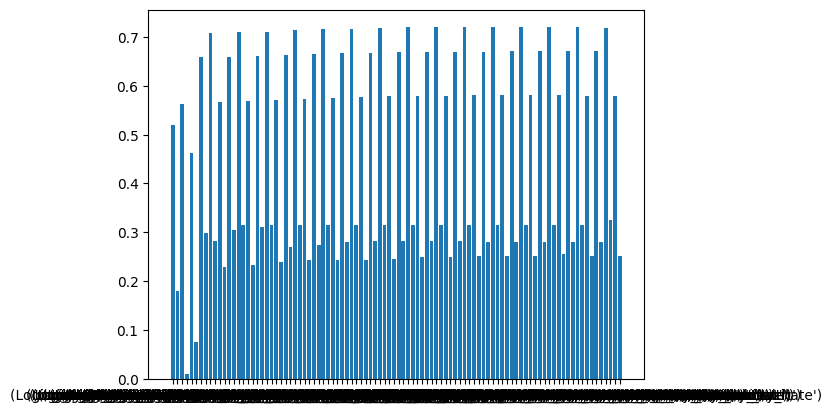

In [13]:
keys = [str(a) for a in view.keys()]

plt.bar(keys, view.values())

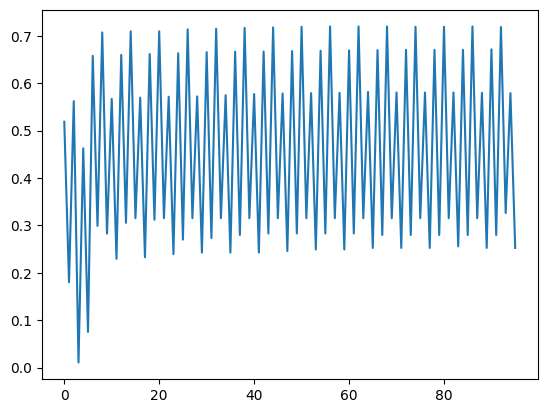